In [9]:
# Loading required libraries
import pandas as pd
import networkx as nx
import numpy as np
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from community import community_louvain
import matplotlib.pyplot as plt
import random
from concurrent.futures import ThreadPoolExecutor
from itertools import combinations
from collections import defaultdict
import scipy.optimize as opt
from tqdm import tqdm
from scipy.sparse import csr_matrix, lil_matrix
from scipy.stats import hypergeom
import seaborn as sns
from collections import defaultdict
from itertools import islice

In [ ]:
# Getting the reviewers and movies separated directly from the graph
reviewers = set()
movies = set()

with open("rec-movielens.edges") as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) == 3:  # Since 3 columns in data: reviewer, movie, score
            reviewer, movie, _ = parts
            # Adding prefix to avoid self-loops: R for reviewers and M for movies
            reviewers.add(f"R_{reviewer}") 
            movies.add(f"M_{movie}")       

# Generating the graph
B = nx.Graph() 
with open("rec-movielens.edges") as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) == 3:
            reviewer, movie, weight = parts
            B.add_edge(f"R_{reviewer}", f"M_{movie}", weight=float(weight))

# Assigning the bipartite attribute to our nodes
# 0 for reviewers
nx.set_node_attributes(B, {n: 0 for n in reviewers}, "bipartite")
# 1 for movies
nx.set_node_attributes(B, {n: 1 for n in movies}, "bipartite")

# Extracting the reviewers and movies from the graph using the bipartite attribute from above
reviewers = {n for n, d in B.nodes(data=True) if d.get("bipartite") == 0}
movies = {n for n, d in B.nodes(data=True) if d.get("bipartite") == 1}

# Printing the N of nodes
print(f"Number of reviewers: {len(reviewers)}")
print(f"Number of movies: {len(movies)}")

Number of reviewers: 69878
Number of movies: 10677


In [6]:
# Loading the data as a dataframe
df = pd.read_csv("rec-movielens.edges", sep=" ", header=None, names=["reviewer", "movie", "weight"])

# Add prefixes to avoid self-loops
df["reviewer"] = "R_" + df["reviewer"].astype(str)
df["movie"] = "M_" + df["movie"].astype(str)

# Print the number of unique reviewers and movies
print("Number of reviewers:", df["reviewer"].nunique())
print("Number of movies:", df["movie"].nunique())

Number of reviewers: 69878
Number of movies: 10677


In [23]:
# Params
keep = 0.1  # 10% reviewers
max_bin = 7  # max bins

# Review counts
reviewer_counts = df.groupby("reviewer")["movie"].count()
reviewer_counts.name = "count"
total_reviewers = len(reviewer_counts)
target_size = int(keep * total_reviewers)

print(f"Reviewers: {total_reviewers}, Target: {target_size}")

# Binning
bins = min(max_bin, reviewer_counts.nunique())
print(f"Bins: {bins}")
strata_labels = [f"Bin_{i+1}" for i in range(bins)]
strata = pd.qcut(reviewer_counts, q=bins, labels=strata_labels, duplicates="drop")

# Sampling
sampled_reviewers = []
stratum_sizes = strata.value_counts().sort_index()
print(f"Stratum sizes:\n{stratum_sizes}")

# Set a fixed random seed for reproducibility
random_seed = 33

for label in strata_labels:
    reviewers_bin = reviewer_counts[strata == label]
    if len(reviewers_bin) == 0:
        continue
    n_sample = int(len(reviewers_bin) / total_reviewers * target_size)
    n_sample = min(n_sample, len(reviewers_bin))
    sampled = reviewers_bin.sample(n=n_sample, random_state=random_seed).index.tolist()
    sampled_reviewers.extend(sampled)

print(f"Sampled reviewers: {len(sampled_reviewers)}")

# Filter data
if df["reviewer"].dtype != pd.Series(sampled_reviewers).dtype:
    sampled_reviewers = [str(r) for r in sampled_reviewers]
    df["reviewer"] = df["reviewer"].astype(str)

df_sample = df[df["reviewer"].isin(sampled_reviewers)]
print(f"Filtered rows: {len(df_sample)}, Reviewers: {df_sample['reviewer'].nunique()}")

# Saving the sampled data
df_sample.to_csv("sampled_reviewers.csv", index=False, sep=" ", header=False)

Reviewers: 69878, Target: 6987
Bins: 7
Stratum sizes:
count
Bin_1    10341
Bin_2    10001
Bin_3    10035
Bin_4     9728
Bin_5     9870
Bin_6     9967
Bin_7     9936
Name: count, dtype: int64
Sampled reviewers: 6982
Filtered rows: 994563, Reviewers: 6982


In [24]:
df_sample["reviewer"].nunique()
df_sample["movie"].nunique()

10117

In [25]:
# Checking reviewers by number of movies reviewed
reviewer_counts = df.groupby("reviewer")["movie"].count()
reviewer_counts.name = "review_count"

# Sort by review_count in descending order
reviewer_counts = reviewer_counts.sort_values(ascending=False)
# Reset the index
reviewer_counts = reviewer_counts.reset_index()
reviewer_counts

,reviewer,review_count
0,R_59269,7359
1,R_67385,7047
2,R_14463,5169
3,R_68259,4483
4,R_27468,4449
...,...,...
69873,R_59985,20
69874,R_55854,20
69875,R_12131,20
69876,R_52415,20


In [2]:
df_sample = pd.read_csv('sampled_reviewers.csv', sep=' ', header=None, names=['reviewer', 'movie', 'weight'])
df_sample
#Get the number of reviewers and movies in the sampled data
print("Number of reviewers in sampled data:", df_sample["reviewer"].nunique())
print("Number of movies in sampled data:", df_sample["movie"].nunique())


Number of reviewers in sampled data: 6982
Number of movies in sampled data: 10117


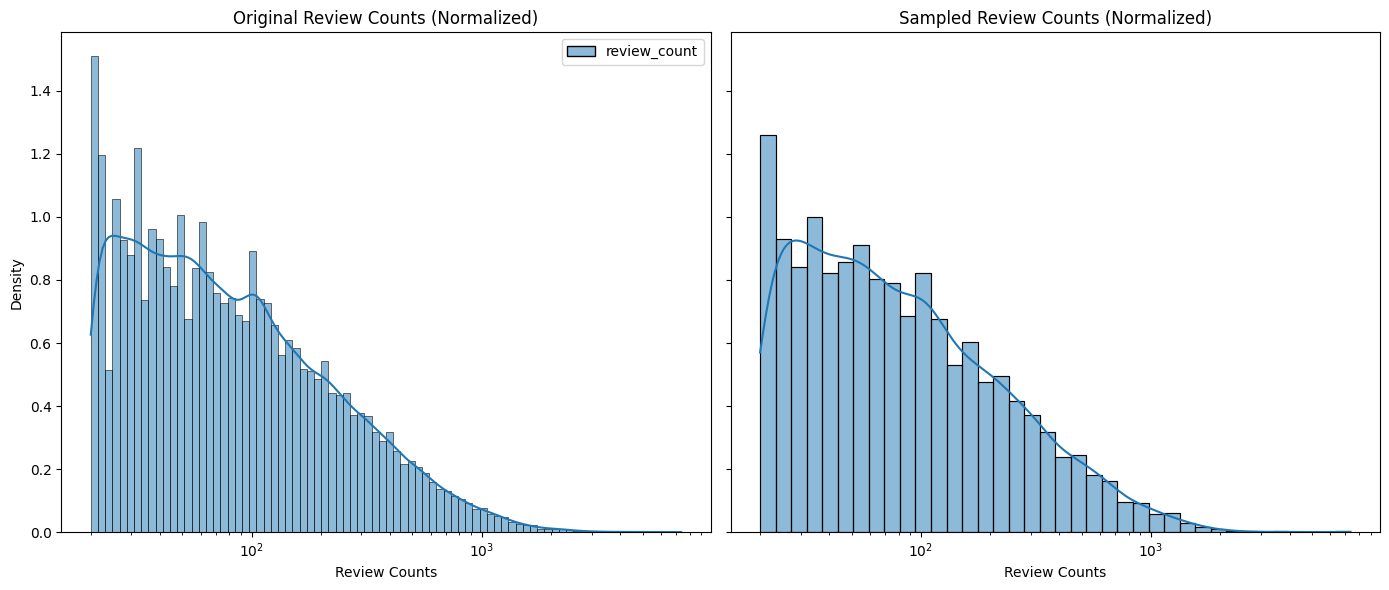

In [27]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Original distribution (normalized to density)
sns.histplot(
    reviewer_counts,
    log_scale=True,
    kde=True,
    ax=axes[0],
    stat="density"  # Normalize to density
)
axes[0].set_title("Original Review Counts (Normalized)")
axes[0].set_xlabel("Review Counts")
axes[0].set_ylabel("Density")

# Sampled distribution (normalized to density)
sns.histplot(
    df_sample.groupby("reviewer")["movie"].count(),
    log_scale=True,
    kde=True,
    ax=axes[1],
    stat="density"  # Normalize to density
)
axes[1].set_title("Sampled Review Counts (Normalized)")
axes[1].set_xlabel("Review Counts")

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [3]:
# Create the sampled bipartite graph B_sample
B_sample = nx.from_pandas_edgelist(
    df_sample,
    source="reviewer",
    target="movie",
    edge_attr="weight",
    create_using=nx.Graph(),
)

# Assign bipartite attributes to nodes in B_sample
reviewers_sample = set(df_sample["reviewer"])
movies_sample = set(df_sample["movie"])
nx.set_node_attributes(B_sample, {n: 0 for n in reviewers_sample}, "bipartite")
nx.set_node_attributes(B_sample, {n: 1 for n in movies_sample}, "bipartite")

num_nodes = B_sample.number_of_nodes()
print(f"Number of nodes in B_sample: {num_nodes}")
num_edges = B_sample.number_of_edges()
print(f"Number of edges in B_sample: {num_edges}")

Number of nodes in B_sample: 17099
Number of edges in B_sample: 994563


In [4]:
# Compute degree distribution for reviewers and movies
reviewer_degrees = [deg for node, deg in B_sample.degree() if B_sample.nodes[node]["bipartite"] == 0]
movie_degrees = [deg for node, deg in B_sample.degree() if B_sample.nodes[node]["bipartite"] == 1]

# Calculate the average degree for each set
avg_reviewer_degree = np.mean(reviewer_degrees)
avg_movie_degree = np.mean(movie_degrees)

print(f"Average degree for reviewers: {avg_reviewer_degree}")
print(f"Average degree for movies: {avg_movie_degree}")

# Generate PDF and CDF for reviewers
reviewer_degree_counts = np.bincount(reviewer_degrees)
reviewer_pdf = reviewer_degree_counts / sum(reviewer_degree_counts)
reviewer_cdf = np.cumsum(reviewer_pdf)


Average degree for reviewers: 142.4467201374964
Average degree for movies: 98.30611841454977


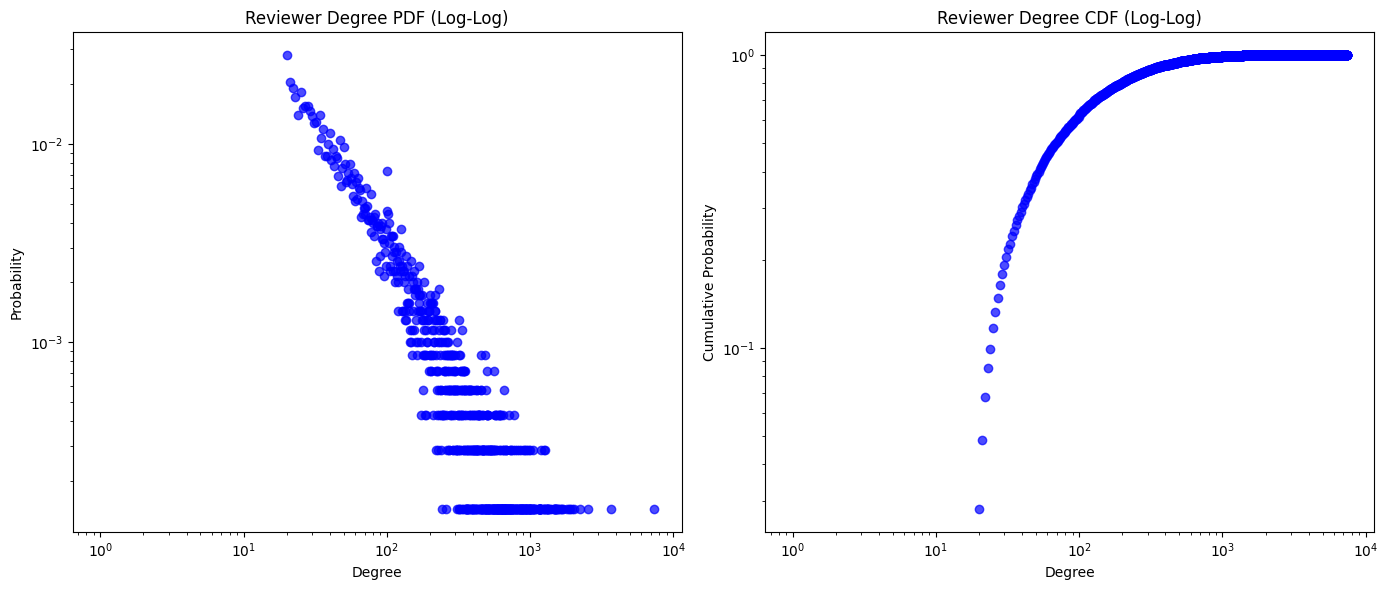

In [38]:
# Generate PDF and CDF for reviewers
reviewer_degree_counts = np.bincount(reviewer_degrees)
reviewer_pdf = reviewer_degree_counts / sum(reviewer_degree_counts)
reviewer_cdf = np.cumsum(reviewer_pdf)

# Plot log-log PDF and CDF for reviewers
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].scatter(range(len(reviewer_pdf)), reviewer_pdf, color="blue", alpha=0.7)
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_title("Reviewer Degree PDF (Log-Log)")
axes[0].set_xlabel("Degree")
axes[0].set_ylabel("Probability")

axes[1].scatter(range(len(reviewer_cdf)), reviewer_cdf, color="blue", alpha=0.7)
axes[1].set_xscale("log")
axes[1].set_yscale("log")
axes[1].set_title("Reviewer Degree CDF (Log-Log)")
axes[1].set_xlabel("Degree")
axes[1].set_ylabel("Cumulative Probability")

plt.tight_layout()
plt.show()

Graph has 6982 nodes and 19118275 edges.
Degree Assortativity Coefficient: -0.15
Number of Louvain communities: 3
Average Degree Centrality: 0.7845

Top 10 Influencers by Degree Centrality:
1. R_50216: 0.9967
2. R_533: 0.9967
3. R_38316: 0.9966
4. R_26127: 0.9964
5. R_19587: 0.9963
6. R_65692: 0.9960
7. R_8127: 0.9960
8. R_23734: 0.9958
9. R_25502: 0.9958
10. R_61805: 0.9958


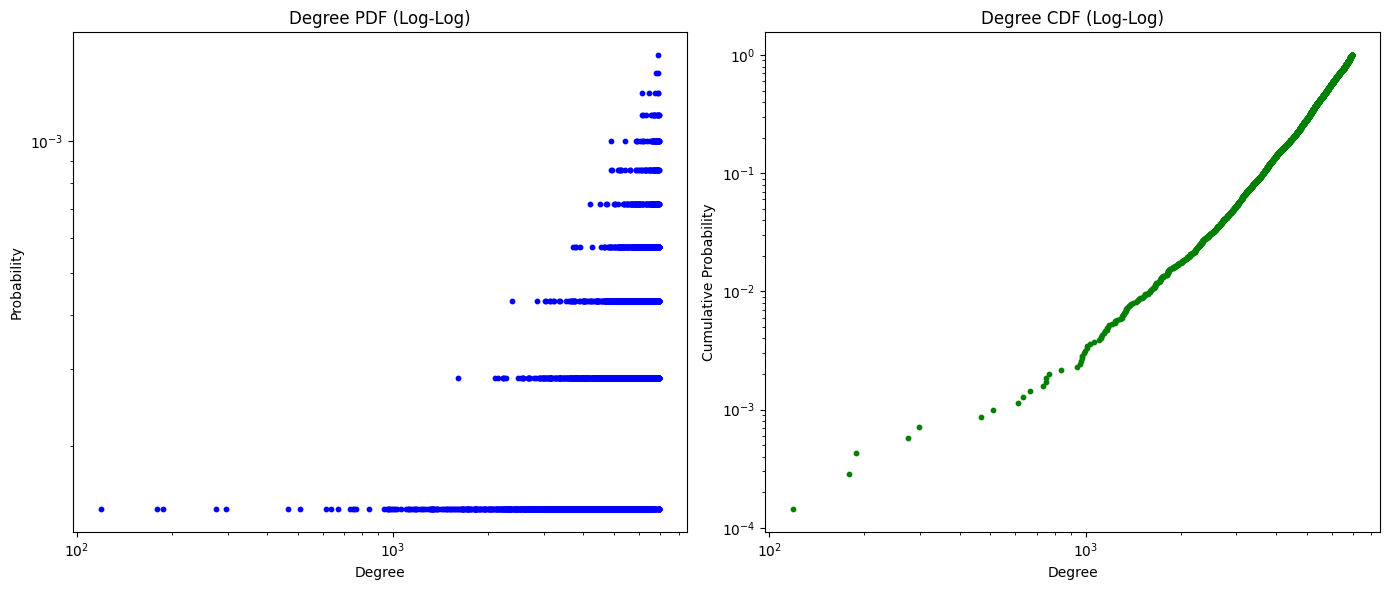

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from community import community_louvain

# load final graph
input_file = "final_graph.edges"
G = nx.read_edgelist(input_file, nodetype=str, data=(("weight", float),))

# Basic statistics
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

assortativity = nx.degree_assortativity_coefficient(G)
print(f"Degree Assortativity Coefficient: {assortativity:.2f}")

# Community and clustering analysis
partition = community_louvain.best_partition(G)
num_communities = len(set(partition.values()))
print(f"Number of Louvain communities: {num_communities}")
# degree centrality
degree_centrality = nx.degree_centrality(G)
avg_degree_centrality = np.mean(list(degree_centrality.values()))
print(f"Average Degree Centrality: {avg_degree_centrality:.4f}")

# top-10 influencers
top_influencers = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 Influencers by Degree Centrality:")
for i, (influencer, centrality) in enumerate(top_influencers, start=1):
    print(f"{i}. {influencer}: {centrality:.4f}")

# Degree distribution
degree_sequence = [deg for _, deg in G.degree()]
degree_count = Counter(degree_sequence)

# PDF
degrees = sorted(degree_count.keys())
pdf = [degree_count[d] / sum(degree_count.values()) for d in degrees]

# CDF
cdf = np.cumsum(pdf)

#Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].scatter(degrees, pdf, color='blue', s=10)
axs[0].set_title("Degree PDF (Log-Log)")
axs[0].set_xlabel("Degree")
axs[0].set_ylabel("Probability")
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].scatter(degrees, cdf, color='green', s=10)
axs[1].set_title("Degree CDF (Log-Log)")
axs[1].set_xlabel("Degree")
axs[1].set_ylabel("Cumulative Probability")
axs[1].set_xscale('log')
axs[1].set_yscale('log')

plt.tight_layout()
plt.show()



Top Influencers and their Edge Counts:
R_533: 599 edges
R_19587: 599 edges
R_25502: 599 edges
R_8127: 599 edges
R_65692: 599 edges
R_50216: 599 edges
R_23734: 599 edges
R_61805: 599 edges
R_38316: 599 edges
R_26127: 599 edges


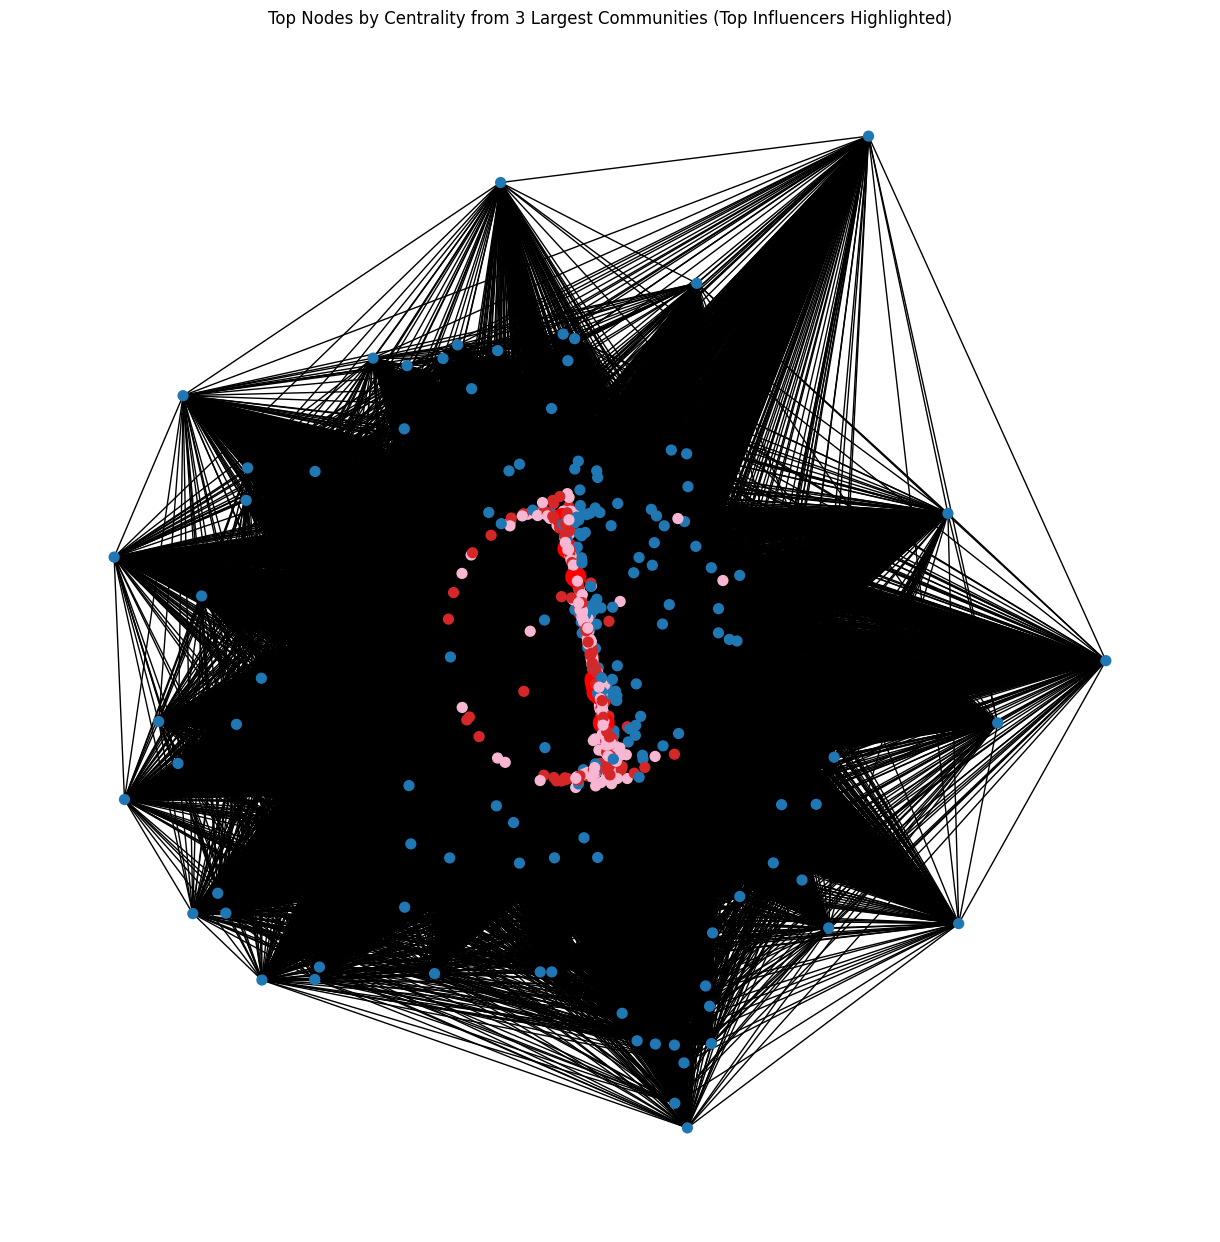

In [13]:
community_nodes = defaultdict(list)
for node, comm in partition.items():
    community_nodes[comm].append(node)

# Select top 3 communities by size
top_communities = sorted(community_nodes.keys(), key=lambda c: len(community_nodes[c]), reverse=True)[:3]

# Select top 500 nodes from each community based on degree centrality
top_nodes = []
degree_centrality = nx.degree_centrality(G)
for comm in top_communities:
    nodes_in_comm = community_nodes[comm]
    top_nodes_in_comm = sorted(nodes_in_comm, key=lambda n: degree_centrality[n], reverse=True)[:200]
    top_nodes.extend(top_nodes_in_comm)

# Create a subgraph with the selected nodes
subgraph = G.subgraph(top_nodes)

# Identify top influencers (e.g., top 10 by degree centrality)
top_influencers = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
top_influencer_nodes = {influencer for influencer, _ in top_influencers}

# Print the edge count for each influencer
print("\nTop Influencers and their Edge Counts:")
for influencer in top_influencer_nodes:
    if influencer in subgraph:
        edge_count = subgraph.degree[influencer]
        print(f"{influencer}: {edge_count} edges")

# Create a color map: distinct color for top influencers, normalized community colors for others
unique_communities = list(set(partition.values()))
community_color_map = {comm: idx for idx, comm in enumerate(unique_communities)}

# Map community IDs to a colormap and ensure all values are valid
node_colors = [
    'red' if node in top_influencer_nodes else plt.cm.tab20(community_color_map[partition[node]] / len(unique_communities))
    for node in subgraph.nodes()
]

# Adjust node sizes: larger size for top influencers
node_sizes = [
    200 if node in top_influencer_nodes else 50
    for node in subgraph.nodes()
]

# Plot the subgraph with highlighted top influencers
pos = nx.spring_layout(subgraph, seed=42)
plt.figure(figsize=(12, 12))
nx.draw(
    subgraph,
    pos,
    node_color=node_colors,
    node_size=node_sizes,
    with_labels=False
)
plt.title("Top Nodes by Centrality from 3 Largest Communities (Top Influencers Highlighted)")
plt.show()

In [ ]:
# Compare review scores of top influencers
influencer_scores = []
for influencer, _ in top_influencers:
    if influencer in df_sample["reviewer"].values:
        scores = df_sample[df_sample["reviewer"] == influencer]["weight"].sum()
        influencer_scores.append((influencer, scores))

print("\nTop 10 influencers and their total review scores:")
for influencer, score in influencer_scores:
    print(f"{influencer}: {score}")

# Visualize the communities
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)
colors = [partition[node] for node in G.nodes()]
nx.draw(
    G,
    pos,
    node_color=colors,
    with_labels=False,
    node_size=50,
    cmap=plt.cm.tab20
)
plt.title("Community Visualization")
plt.show()